### Analysis using SARIMAX model for Time Series

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.dates as mdates
import warnings

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
# Ignoring warnings
warnings.filterwarnings("ignore")

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})
%matplotlib inline

#### Importing already collected data

In [3]:
df_daily = pd.read_csv("./datasets/proc/daily_variables.csv.zip", index_col = 0, parse_dates=["date"])
df_monthly = pd.read_csv("./datasets/proc/monthly_variables.csv.zip", index_col = 0, parse_dates=["date"])

#### Preprocessing for the analysis

In [4]:
# Scaling values
df_daily[df_daily.set_index('date').columns] = MinMaxScaler().fit_transform(df_daily[df_daily.set_index('date').columns])
df_monthly[df_monthly.set_index('date').columns] = MinMaxScaler().fit_transform(df_monthly[df_monthly.set_index('date').columns])

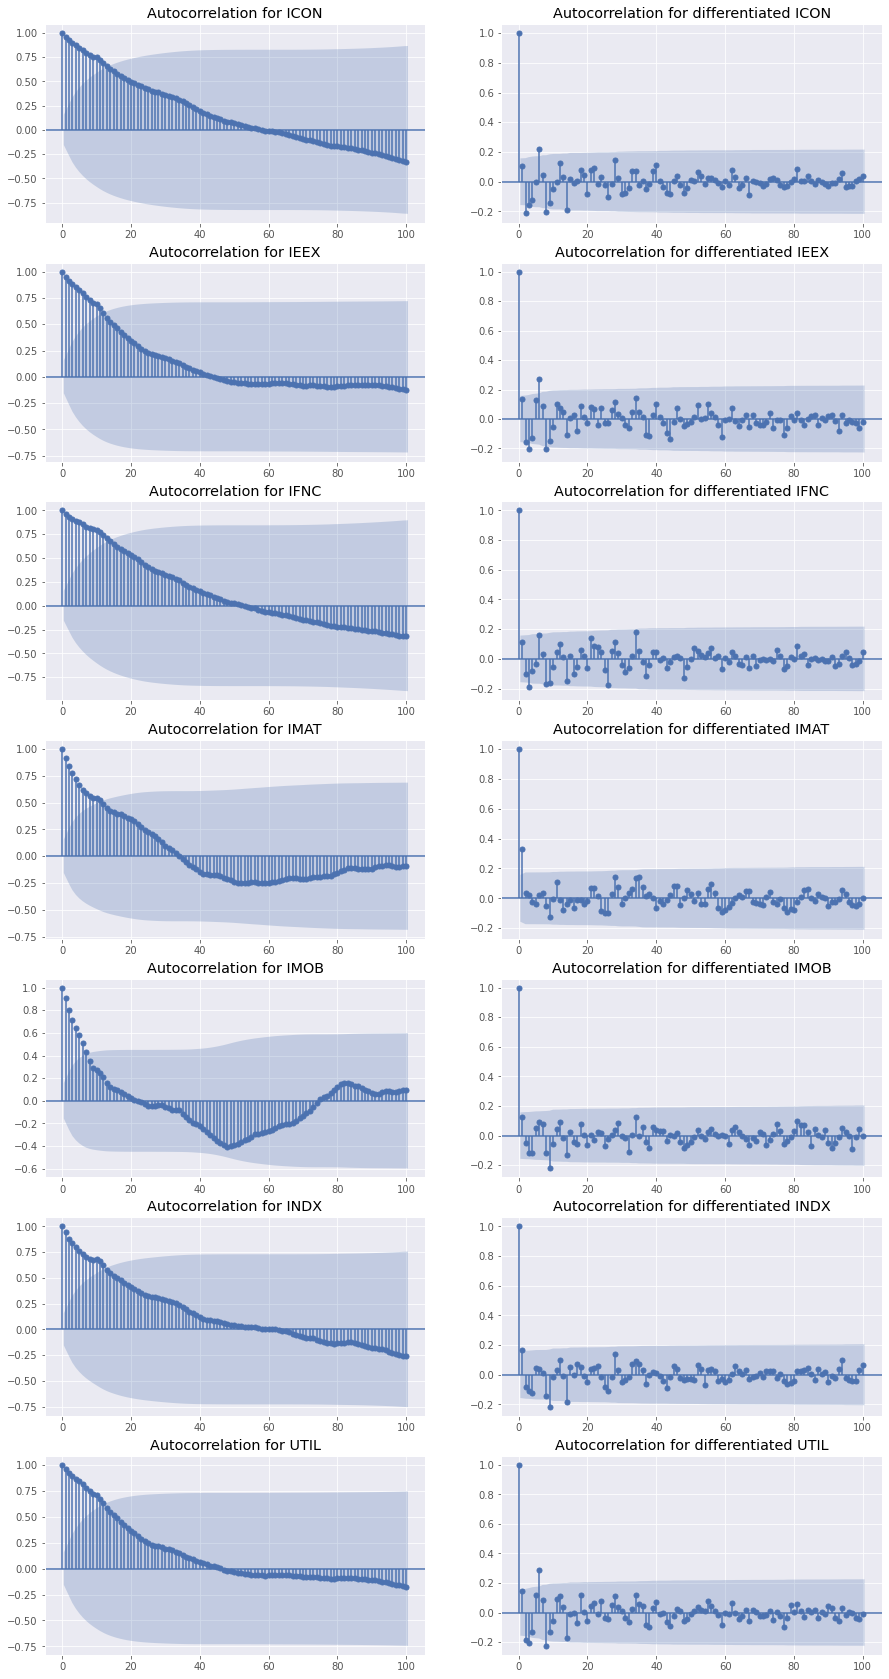

In [5]:
figure, axs = plt.subplots(7,2,figsize=(15,30))

for i in range(7):
    current_column = df_daily.set_index("date").columns[i]
    data = np.asarray(df_monthly[current_column])
    data_disl = data[1:]
    data_trunc = data[:-1]
    data_diff = data_disl - data_trunc
    plot_acf(data, lags=100, ax=axs[i,0], title=f"Autocorrelation for {current_column}")
    plot_acf(data_diff, lags=100, ax=axs[i,1], title=f"Autocorrelation for differentiated {current_column}")

plt.show()

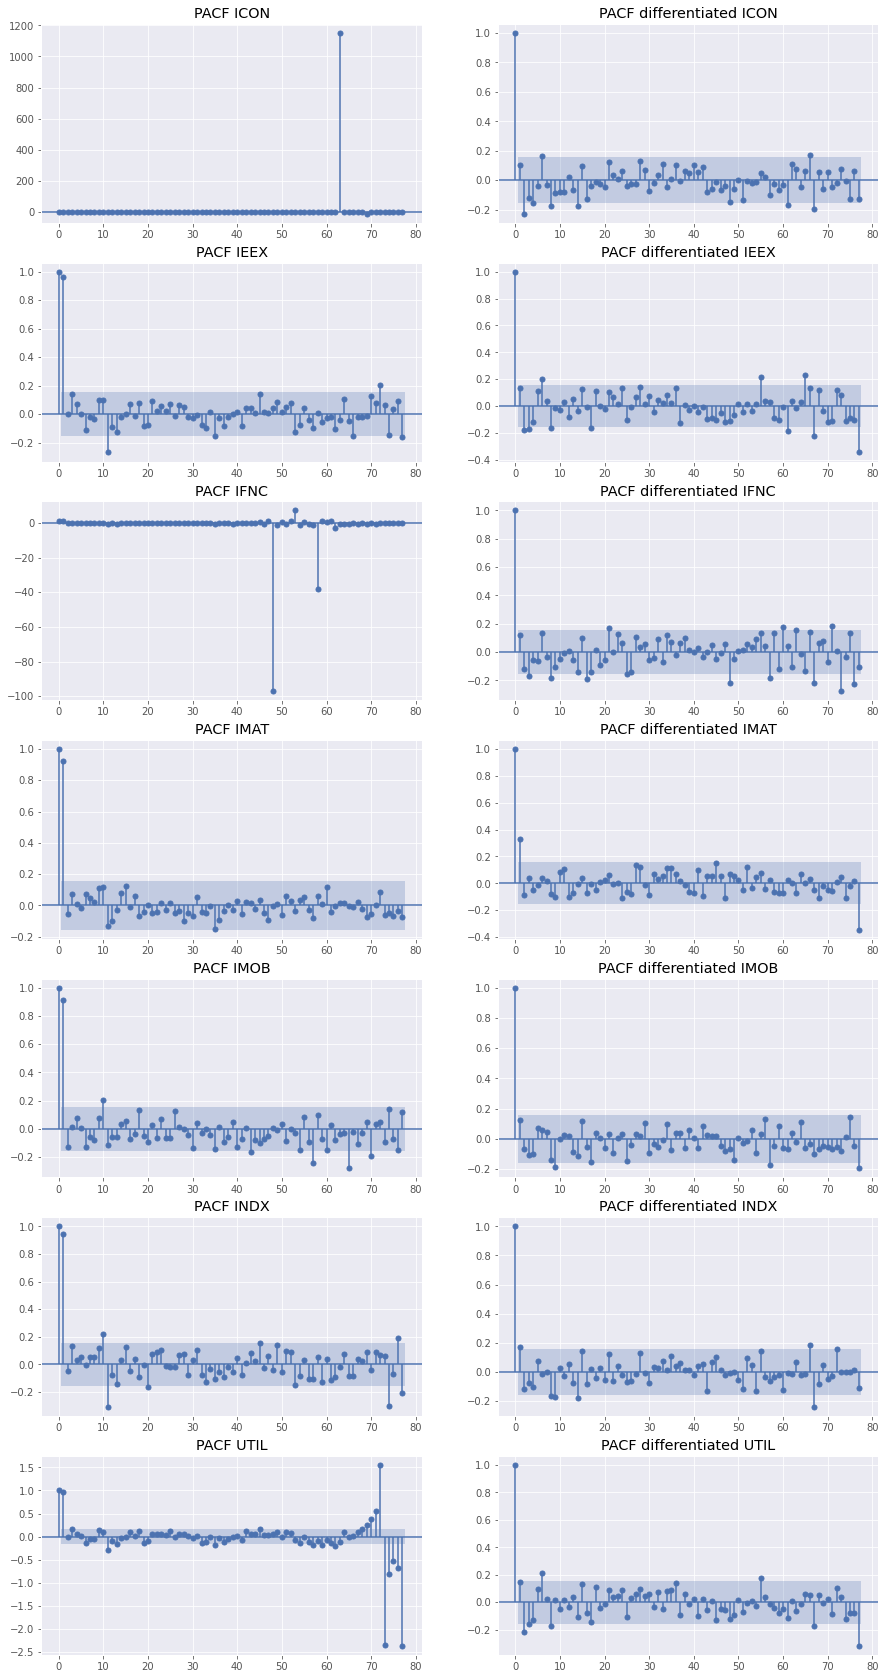

In [6]:
figure, axs = plt.subplots(7,2,figsize=(15,30))

for i in range(7):
    current_column = df_daily.set_index("date").columns[i]
    data = np.asarray(df_monthly[current_column])
    data_disl = data[1:]
    data_trunc = data[:-1]
    data_diff = data_disl - data_trunc
    plot_pacf(data, lags=77, ax=axs[i,0], title=f"PACF {current_column}")
    plot_pacf(data_diff, lags=77, ax=axs[i,1], title=f"PACF differentiated {current_column}")

plt.show()

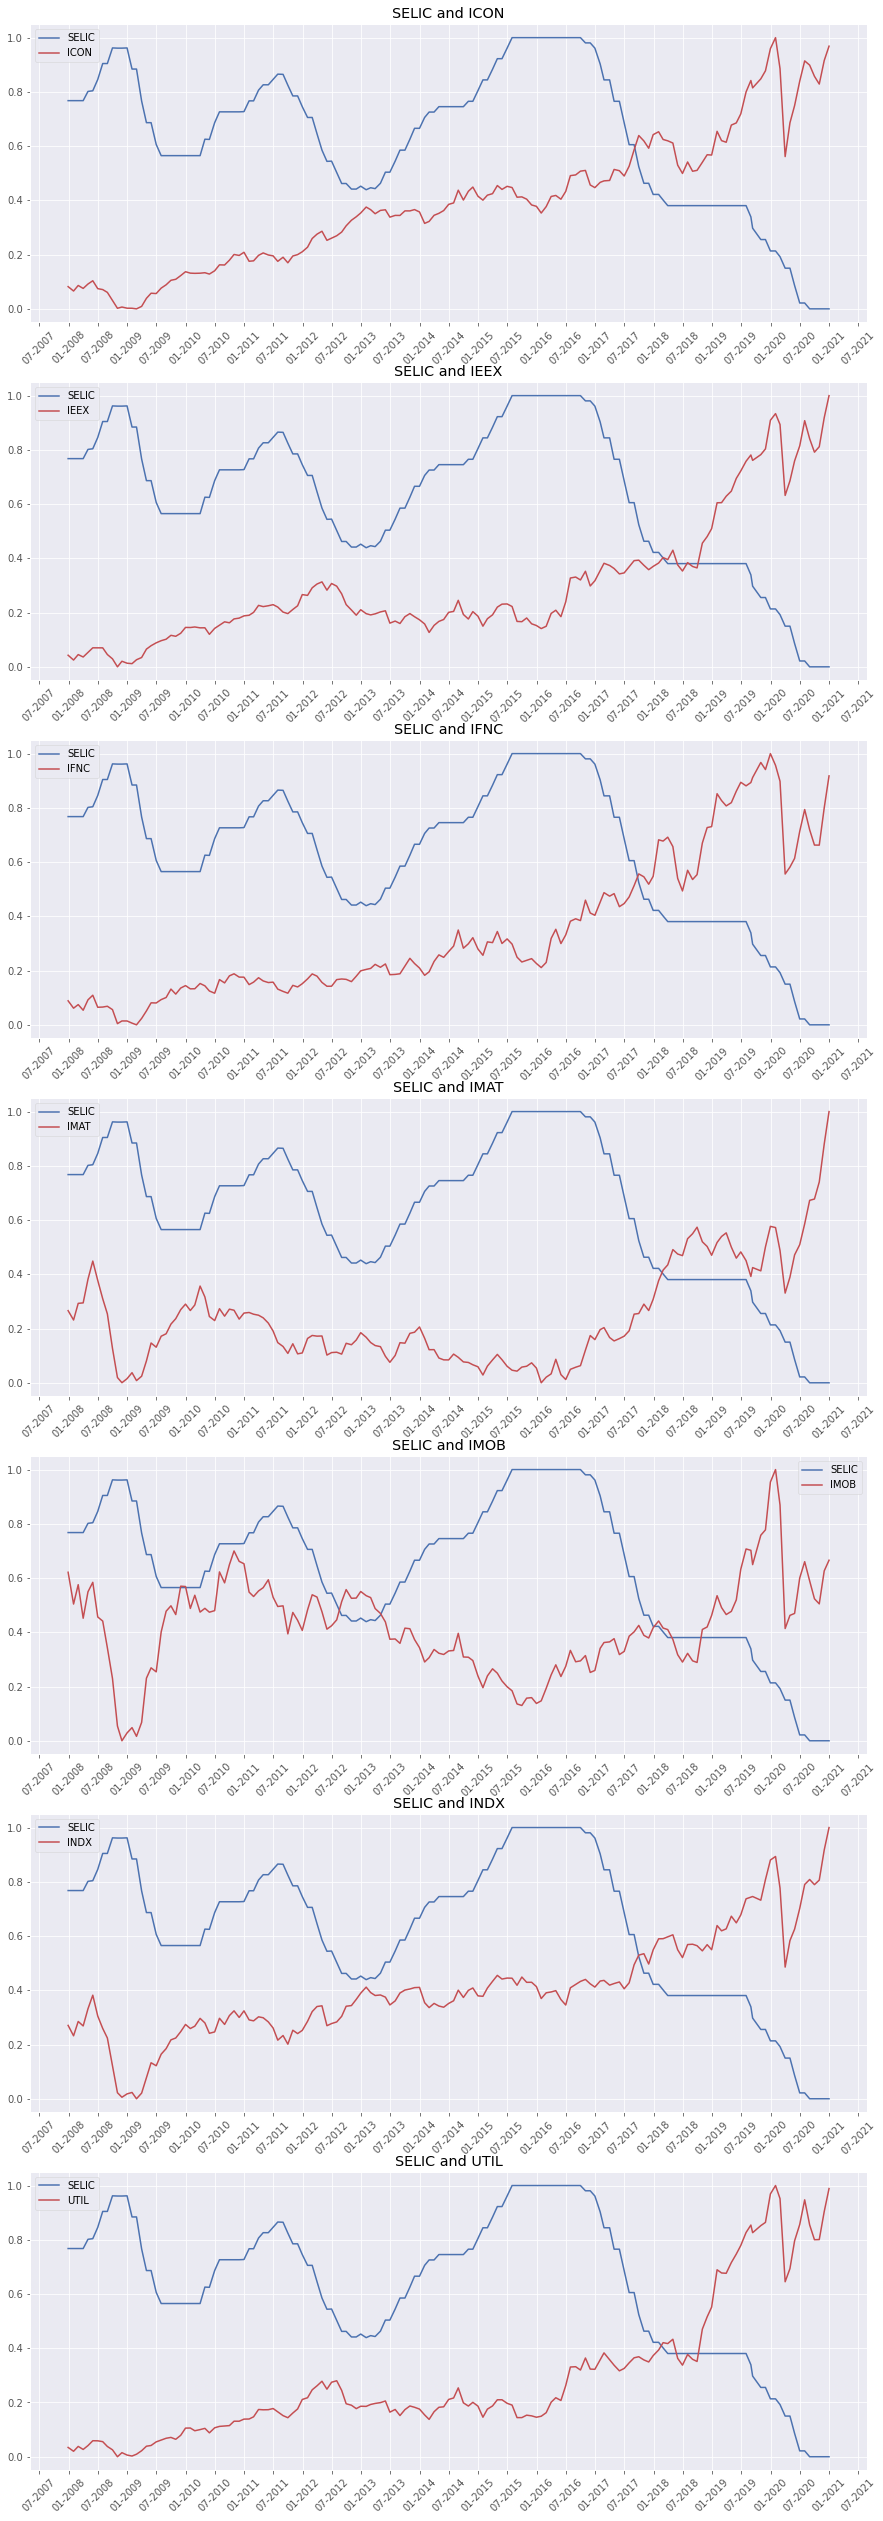

In [7]:
figure, axs = plt.subplots(7,1,figsize=(15,45))

for i in range(7):
    current_column = df_daily.set_index("date").columns[i]
    axs[i].plot(df_monthly["date"], df_monthly["SELIC"], label="SELIC")
    axs[i].plot(df_monthly["date"], df_monthly[current_column], label=f"{current_column}")
    axs[i].set_title(f"SELIC and {current_column}")
    axs[i].legend()
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
plt.show()

### Performing Time Series Analysis

### ICON

In [15]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["ICON"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False)
    result = model.fit()
    print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
    if result.aic < minAIC:
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -412.13916429473585
                                     SARIMAX Results                                      
Dep. Variable:                               ICON   No. Observations:                  157
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 274.248
Date:                            Sun, 04 Apr 2021   AIC                           -534.496
Time:                                    00:17:21   BIC                           -513.756
Sample:                                         0   HQIC                          -526.068
                                            - 157                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       5.001e-06   3.19e-05      0.157      0.8

### IEEX

In [9]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["IEEX"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
    if result.aic < minAIC:
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -264.13412488779564
                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.IEEX   No. Observations:                  144
Model:             SARIMAX(0, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 267.324
Date:                            Sun, 04 Apr 2021   AIC                           -520.648
Time:                                    00:04:13   BIC                           -499.909
Sample:                                         0   HQIC                          -512.221
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        1.79e-05   3.74e-05      0.478      0.6

### IFNC

In [10]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["IFNC"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
    if result.aic < minAIC:
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -387.86301096025176
                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.IFNC   No. Observations:                  144
Model:             SARIMAX(0, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 246.473
Date:                            Sun, 04 Apr 2021   AIC                           -478.946
Time:                                    00:05:14   BIC                           -458.206
Sample:                                         0   HQIC                          -470.518
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       4.002e-08   4.24e-05      0.001      0.9

### IMAT

In [16]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["IMAT"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False)
    result = model.fit()
    print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
    if result.aic < minAIC:
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -397.27362110893665
                                      SARIMAX Results                                       
Dep. Variable:                                 IMAT   No. Observations:                  157
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 245.115
Date:                              Sun, 04 Apr 2021   AIC                           -472.230
Time:                                      00:19:35   BIC                           -446.354
Sample:                                           0   HQIC                          -461.716
                                              - 157                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       2.987e-05   1.42e-05    

### IMOB

In [12]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["IMOB"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
    if result.aic < minAIC:
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -329.04943411526045
                                      SARIMAX Results                                       
Dep. Variable:                          D.DS12.IMOB   No. Observations:                  144
Model:             SARIMAX(0, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 198.463
Date:                              Sun, 04 Apr 2021   AIC                           -378.926
Time:                                      00:07:39   BIC                           -353.050
Sample:                                           0   HQIC                          -368.411
                                              - 144                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        2.52e-06   4.59e-05    

### INDX

In [13]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["INDX"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
    if result.aic < minAIC:
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -419.33892205266345
                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.INDX   No. Observations:                  144
Model:             SARIMAX(0, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 264.023
Date:                            Sun, 04 Apr 2021   AIC                           -514.046
Time:                                    00:08:44   BIC                           -493.306
Sample:                                         0   HQIC                          -505.619
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       2.014e-05   4.32e-05      0.466      0.6

### UTIL

In [14]:
ps = range(3)
qs = range(3)

ps_season = range(3)
qs_season = range(3)

minAIC, best_parameters, best_model = (float('inf'), (-10,-10), None) 

for p,q,p_season,q_season in [(i, j, k, l) for i in ps for j in qs for k in ps_season for l in qs_season]:
    
    model = sm.tsa.statespace.SARIMAX(df_monthly["UTIL"], df_monthly[["DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]], order=(p, 1, q), seasonal_order=(
    p_season, 1, q_season, 12), trend='t', enforce_inversibility=False, enforce_stationarity=False, simple_differencing=True)
    result = model.fit()
    print(f"\rFor parameters ({p},1,{q})x({p},1,{q},12) -> AIC: {result.aic}", end="")
    if result.aic < minAIC:
        minAIC = result.aic
        best_parameters = (p,q)
        best_model = result

print()
print(best_model.summary())

For parameters (2,1,2)x(2,1,2,12) -> AIC: -406.10761628098877
                                     SARIMAX Results                                      
Dep. Variable:                        D.DS12.UTIL   No. Observations:                  144
Model:             SARIMAX(0, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 256.627
Date:                            Sun, 04 Apr 2021   AIC                           -499.254
Time:                                    00:09:41   BIC                           -478.514
Sample:                                         0   HQIC                          -490.826
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       7.765e-06   3.76e-05      0.206      0.8